# Acceleration with haze removal IP core added into base overlay
----

<div class="alert alert-box alert-info">
Please use Jupyter labs http://&lt;board_ip_address&gt;/lab for this notebook.
</div>

## Download the overlay

In [1]:
from pynq.overlays.base import BaseOverlay
from pynq import Overlay

base_dcp = BaseOverlay("./custom_overlay/base_dcp.bit")

hdmi_in = base_dcp.video.hdmi_in
hdmi_out = base_dcp.video.hdmi_out

## Start HDMI Streaming
please check your connection

In [2]:
hdmi_in.configure()
hdmi_out.configure(hdmi_in.mode)

hdmi_in.start()
hdmi_out.start()

In [18]:
hdmi_in.tie(hdmi_out)

# Hardware Acceleration

In [4]:
base_dcp.haze_removal_0.register_map

RegisterMap {
  CTRL = Register(AP_START=0, AP_DONE=0, AP_IDLE=1, AP_READY=0, RESERVED_1=0, AUTO_RESTART=0, RESERVED_2=0),
  GIER = Register(Enable=0, RESERVED=0),
  IP_IER = Register(CHAN0_INT_EN=0, CHAN1_INT_EN=0, RESERVED=0),
  IP_ISR = Register(CHAN0_INT_ST=0, CHAN1_INT_ST=0, RESERVED=0),
  a_100 = Register(a_100=0),
  img_in_V = Register(img_in_V=0),
  img_out_V = Register(img_out_V=0)
}

## 1. Load Test Image

In [5]:
import cv2

img_name = "forest.jpg"
path = "image/"

img = cv2.imread(path+img_name)
img_resize = cv2.resize(img,(1920,1080))

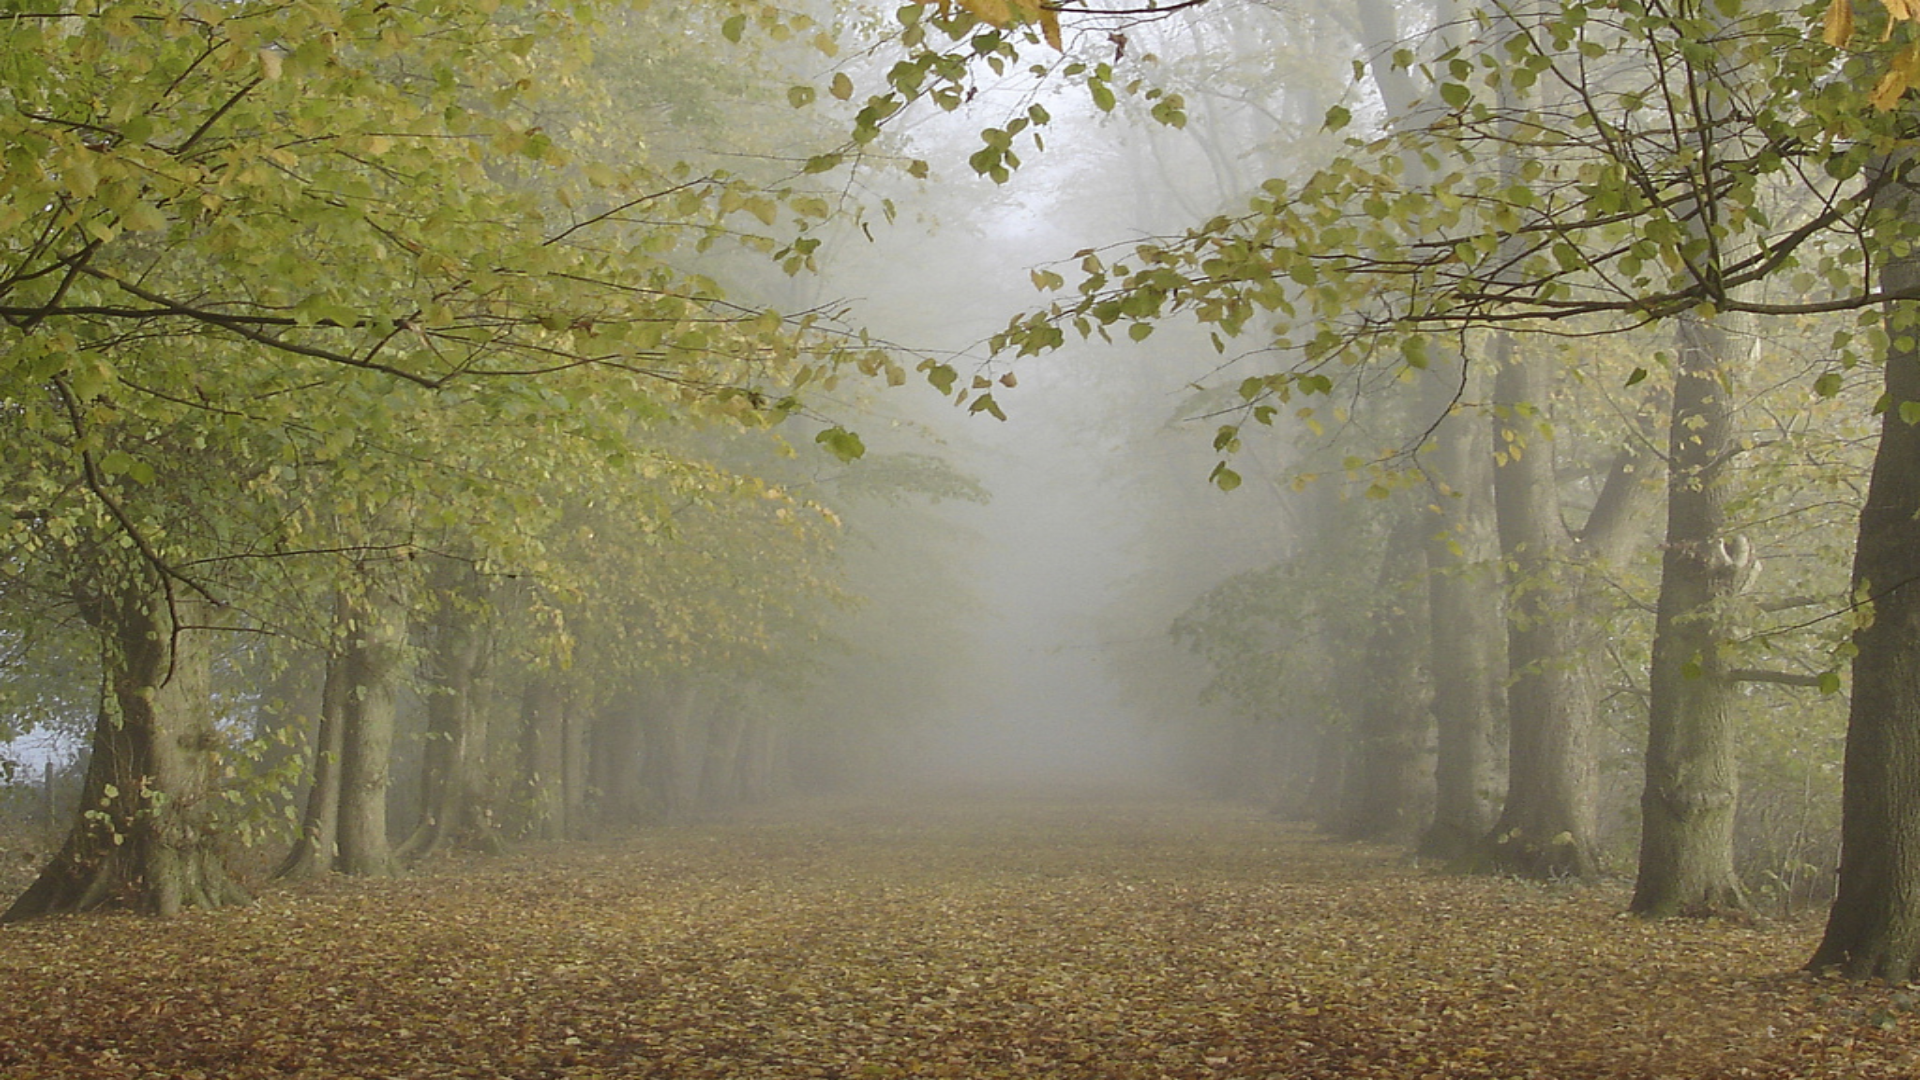

In [6]:
from PIL import Image
im= Image.fromarray(img_resize[:,:,[2,1,0]])
im

## 2. Allocate and Run

In [7]:
from pynq import allocate
import numpy as np 

img_in = allocate(shape=img_resize.shape, dtype=np.uint8)
img_out = allocate(shape=img_resize.shape, dtype=np.uint8)

np.copyto(img_in,img_resize)

In [8]:
base_dcp.haze_removal_0.register_map.a_100 = 15
base_dcp.haze_removal_0.register_map.img_in_V = img_in.physical_address
base_dcp.haze_removal_0.register_map.img_out_V = img_out.physical_address
base_dcp.haze_removal_0.register_map.CTRL.AP_START = 1

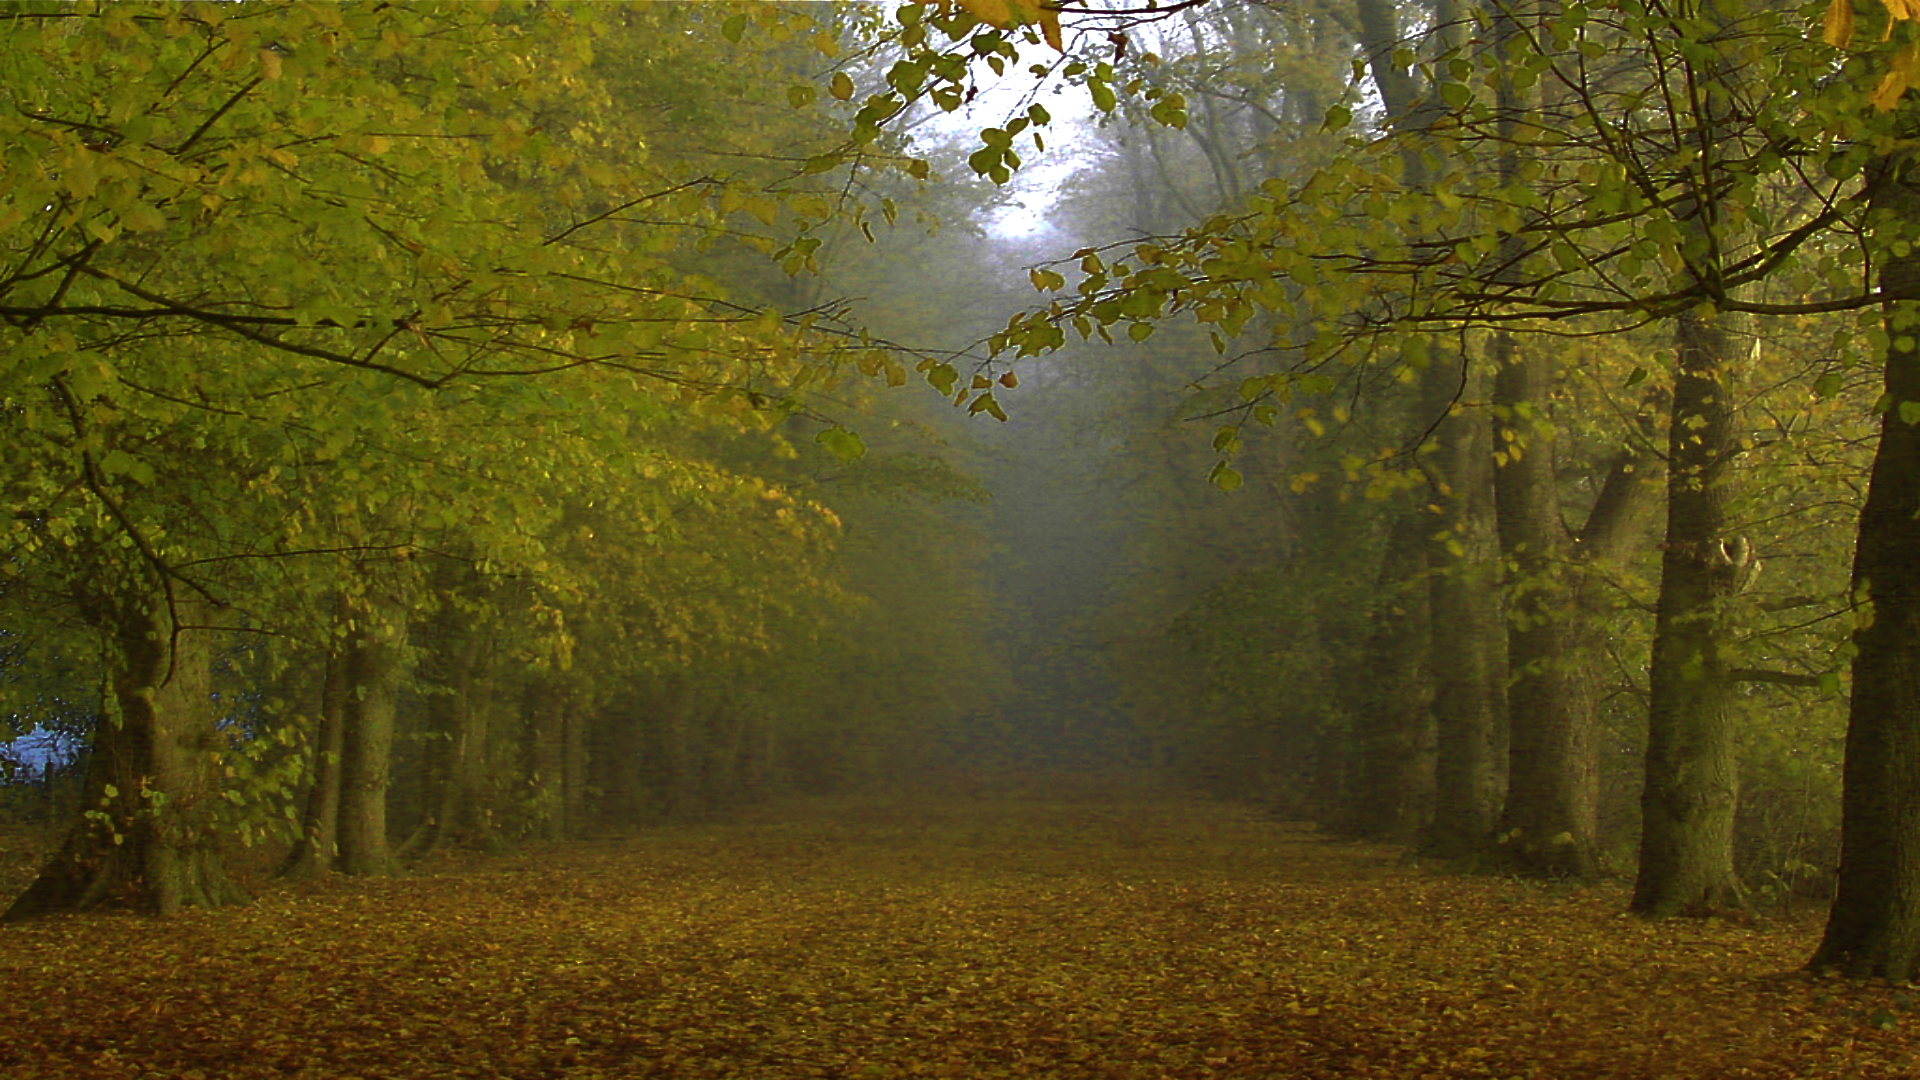

In [9]:
from PIL import Image
im= Image.fromarray(img_out[:,:,[2,1,0]])
im

# Process Video

the input frame is resized to 180P to meet the real-time requirement

In [4]:
from pynq import allocate
import numpy as np
import time

img_out = allocate(shape=(1080, 1920, 3), dtype=np.uint8)
outframe = hdmi_out.newframe()
base_dcp.haze_removal_0.register_map.a_100 = 15
base_dcp.haze_removal_0.register_map.img_out_V = img_out.physical_address

In [ ]:
while True:
    inframe = hdmi_in.readframe()
    base_dcp.haze_removal_0.register_map.img_in_V = inframe.physical_address
    base_dcp.haze_removal_0.register_map.CTRL.AP_START = 1
    time.sleep(1)
    np.copyto(outframe,img_out)
    hdmi_out.writeframe(outframe)

## Reschedule

Reschedule the order of execution to speed up a bit

In [ ]:
while True:
    base_dcp.haze_removal_0.register_map.img_in_V = inframe.physical_address
    base_dcp.haze_removal_0.register_map.CTRL.AP_START = 1
    inframe = hdmi_in.readframe()
    time.sleep(0.2)
    np.copyto(outframe,img_out)

## Count FPS

The FPS is improved from 0.23 to 1.86 in 1080P

In [17]:
numframes = 60
start = time.time()

for _ in range(numframes):
    base_dcp.haze_removal_0.register_map.img_in_V = inframe.physical_address
    base_dcp.haze_removal_0.register_map.CTRL.AP_START = 1
    inframe = hdmi_in.readframe()
    time.sleep(0.2)
    np.copyto(outframe,img_out)
    
end = time.time()
print("Frames per second:  " + str(numframes / (end - start)))

Frames per second:  1.8552012862504341


<div class="alert alert-box alert-info">
Please directly use following code to stop threads, and restart from loading overlay
</div>

<div class="alert alert-heading alert-danger">
    <h4 class="alert-heading">Warning:</h4>

Failure to stop the HDMI Video may hang the board 
when trying to download another bitstream onto the FPGA
</div>

In [19]:
hdmi_out.close()
hdmi_in.close()